# Wetlands Insight Tool sandbox for Raijin edits


### List of wetland edits

push to github every time you change one of these!!!!
- wofs bit flags - include low angle wofs
- check for 90% coverage of shape, not just load
- if no data, redo load with no 90% thing, then monthly aggregate before checking for coverage
-  tighten graph and increase text size


__Future Work:__ 
- do this by max extent of wetness
- add rainfall for context
        

### import modules


In [189]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tci and wofs')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up polygon

In [5]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
poly_path = '/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'

In [36]:
#open the polygon and manually select your favourite polygon the lazy way
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        #first_geometry = next(iter(shapes))['geometry']
        #geom = geometry.Geometry(first_geometry, crs=crs)
        for feature in shapes:
            #print(feature['properties']['WETLAND_NA'])
            if feature['properties']['WETLAND_NA']=='Lake Charm':
                lake_charm =feature
                lake_charm_geometry = lake_charm['geometry']
                geom = geometry.Geometry(lake_charm_geometry, crs=crs)

### Set up query

In [190]:
query = {'geopolygon': geom,
         #'time': ('2016-01-01', '2018-06-30')
         #'time': ('2007-01-01', '2007-06-30')
         'time': ('2018-07-01', '2019-01-01')
         }

### Load cloudmasked data

### mask the data with our original polygon to remove extra data 

In [191]:
landsat_masked_prop = 0.90
ls578 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',masked_prop=landsat_masked_prop)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 7 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [193]:
ls578

<xarray.Dataset>
Dimensions:          (time: 7, x: 129, y: 220)
Coordinates:
  * time             (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
  * y                (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06 -3.942e+06
  * x                (x) float64 1.067e+06 1.067e+06 ... 1.07e+06 1.07e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 345.0 404.0 444.0 ... 729.0 704.0
    blue             (time, y, x) float64 329.0 371.0 424.0 ... 726.0 698.0
    green            (time, y, x) float64 558.0 658.0 756.0 ... 934.0 904.0
    red              (time, y, x) float64 904.0 1.026e+03 ... 1.113e+03
    nir              (time, y, x) float64 1.405e+03 1.643e+03 ... 1.957e+03
    swir1            (time, y, x) float64 2.263e+03 2.51e+03 ... 3.194e+03
    swir2            (time, y, x) float64 1.933e+03 2.089e+03 ... 2.52e+03
    data_perc        (time, y, x) float64 0.9995 0.9995 0.9995 ... 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

In [194]:
data = ls578

mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [195]:
ls578

<xarray.Dataset>
Dimensions:          (time: 7, x: 129, y: 220)
Coordinates:
  * time             (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
  * y                (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06 -3.942e+06
  * x                (x) float64 1.067e+06 1.067e+06 ... 1.07e+06 1.07e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 345.0 404.0 444.0 ... 729.0 704.0
    blue             (time, y, x) float64 329.0 371.0 424.0 ... 726.0 698.0
    green            (time, y, x) float64 558.0 658.0 756.0 ... 934.0 904.0
    red              (time, y, x) float64 904.0 1.026e+03 ... 1.113e+03
    nir              (time, y, x) float64 1.405e+03 1.643e+03 ... 1.957e+03
    swir1            (time, y, x) float64 2.263e+03 2.51e+03 ... 3.194e+03
    swir2            (time, y, x) float64 1.933e+03 2.089e+03 ... 2.52e+03
    data_perc        (time, y, x) float64 0.9995 0.9995 0.9995 ... 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

In [197]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

In [199]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

In [200]:
tci

<xarray.Dataset>
Dimensions:                 (time: 7, x: 129, y: 220)
Coordinates:
  * x                       (x) float64 1.067e+06 1.067e+06 ... 1.07e+06
  * y                       (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06
  * time                    (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
Data variables:
    greenness_thresholded   (time, y, x) float64 nan nan nan nan ... nan nan nan
    brightness_thresholded  (time, y, x) float64 nan nan nan nan ... nan nan nan
    wetness_thresholded     (time, y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:3577

### create a masked version of the extent of overthreshold wetness

In [203]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

In [204]:
# #reapply the polygon mask
tcw = tcw.where(mask_xr==False)

### load wofls and select only wet pixels

# trying to fix wofs flagging

In [205]:
#load wofs
wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

#first, match tcw and wofs

In [208]:
wofls2 = wofls.where(wofls.time ==tci.time)

In [210]:
masking.describe_variable_flags(wofls, with_pandas=True)

,bits,values,description
cloud,6,"{'0': False, '1': True}",Cloudy
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
high_slope,4,"{'0': False, '1': True}",High slope
nodata,0,{'1': True},No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",Terrain shadow or low solar angle
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


In [211]:
#try masking all the things you want to be logical anded at the same time: all of these things must be the case to select a pixel
newnewmasktest = masking.make_mask(wofls, 
                                   water_observed=True, 
                                   #sea=False, 
                                   noncontiguous=False,
                                   high_slope=False, 
                                   cloud_shadow=False,
                                   cloud=False)
#e.g.[7,6,5,4,1,0] -check nodata?
#need to get sea out as well at some time to filter areas on coast

<Figure size 432x288 with 0 Axes>

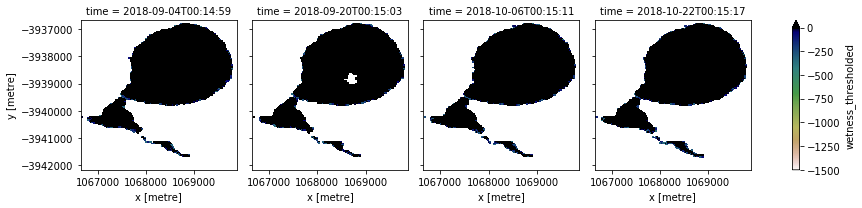

In [212]:
plt.clf()
tci.wetness_thresholded[-5:-1].plot(col='time', cmap='gist_earth_r', col_wrap=4, vmin=-1500, vmax=0)
plt.show()

plot last 

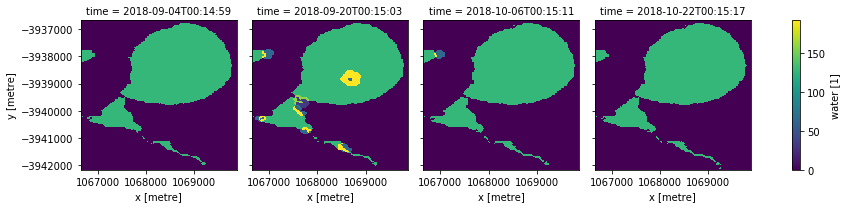

In [263]:
wofls2.water[-5:-1].plot(col='time')

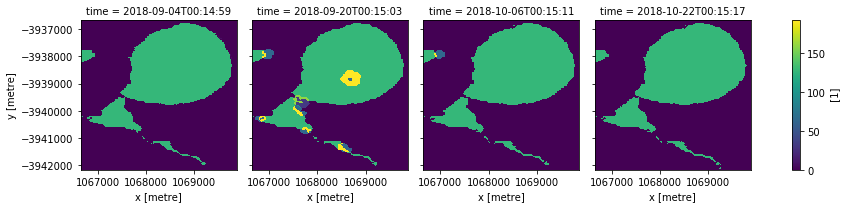

In [214]:
wofls.water.where(wofls2.time == wofls2.time[-5:-1]).plot(col='time')

In [182]:
oldmask =masking.make_mask(wofls, wet=True)

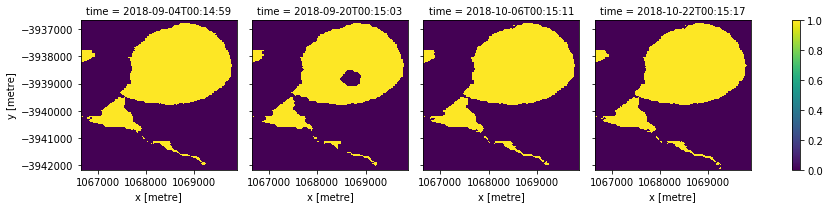

In [215]:
oldmask.water.where(wofls2.time == wofls2.time[-5:-1]).plot(col='time')

In [216]:
lowanglemask =masking.make_mask(wofls,terrain_or_low_angle=True)

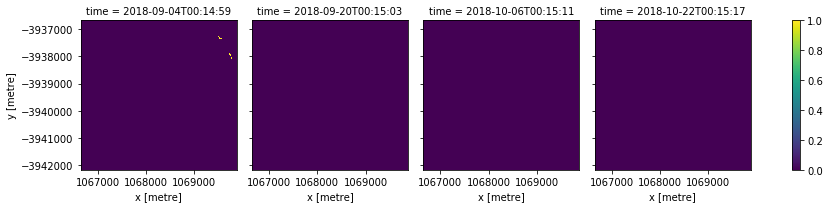

In [217]:
lowanglemask.water.where(wofls2.time == wofls2.time[-5:-1]).plot(col='time')

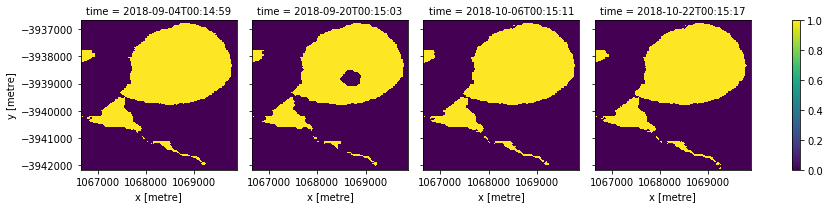

In [218]:
newnewmasktest.water.where(wofls2.time == wofls2.time[-5:-1]).plot(col='time')

In [258]:
#match the wofs observations to the nbart
wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

In [264]:
# #mask the wofs obs with the polygon mask
# wetwofl = wetwofl.where(mask_xr==False)

In [261]:
wetwofl

<xarray.Dataset>
Dimensions:  (time: 7, x: 129, y: 220)
Coordinates:
  * x        (x) float64 1.067e+06 1.067e+06 1.067e+06 ... 1.07e+06 1.07e+06
  * y        (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06 -3.942e+06
  * time     (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
Data variables:
    water    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

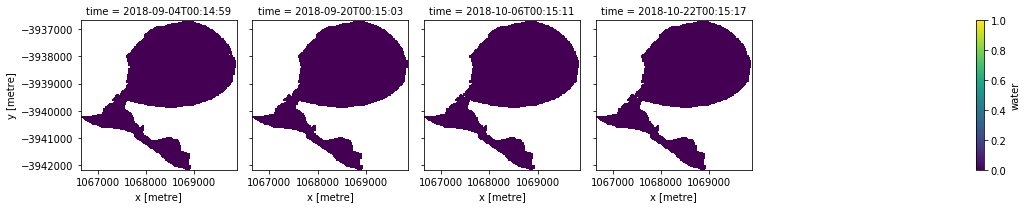

In [262]:
wetwofl.water[-5:-1].plot(col='time', col_wrap=5)

In [265]:
### bitwise or \ for both masks to join together

In [226]:
## checking to make sure the masking is only taking what we want

In [266]:
wofls

<xarray.Dataset>
Dimensions:  (time: 28, x: 129, y: 220)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
  * y        (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06 -3.942e+06
  * x        (x) float64 1.067e+06 1.067e+06 1.067e+06 ... 1.07e+06 1.07e+06
Data variables:
    water    (time, y, x) int16 8 8 8 8 8 8 8 8 8 8 8 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:3577

In [231]:
#only get wet obs
wetwofl = masking.make_mask(wofls, terrain_or_low_angle=True)

In [254]:
wetwofl

<xarray.Dataset>
Dimensions:  (time: 28, x: 129, y: 220)
Coordinates:
  * y        (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06 -3.942e+06
  * x        (x) float64 1.067e+06 1.067e+06 1.067e+06 ... 1.07e+06 1.07e+06
  * time     (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
Data variables:
    water    (time, y, x) bool False False False False ... False False False
Attributes:
    crs:      EPSG:3577

In [232]:
wofls.water.isel(time=-1).max()

<xarray.DataArray 'water' ()>
array(128, dtype=int16)
Coordinates:
    time     datetime64[ns] 2018-12-25T00:15:17

### load in fractional cover data

In [233]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 7 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [237]:
fc_ds

<xarray.Dataset>
Dimensions:    (time: 7, x: 129, y: 220)
Coordinates:
  * x          (x) float64 1.067e+06 1.067e+06 1.067e+06 ... 1.07e+06 1.07e+06
  * y          (y) float64 -3.937e+06 -3.937e+06 ... -3.942e+06 -3.942e+06
  * time       (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17
Data variables:
    BS         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    UE         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    data_perc  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [234]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [238]:
fc_ds_noTCW=fc_ds.where(tcw==False)

In [239]:
#set scene to plot
scene =2

<Figure size 432x288 with 0 Axes>

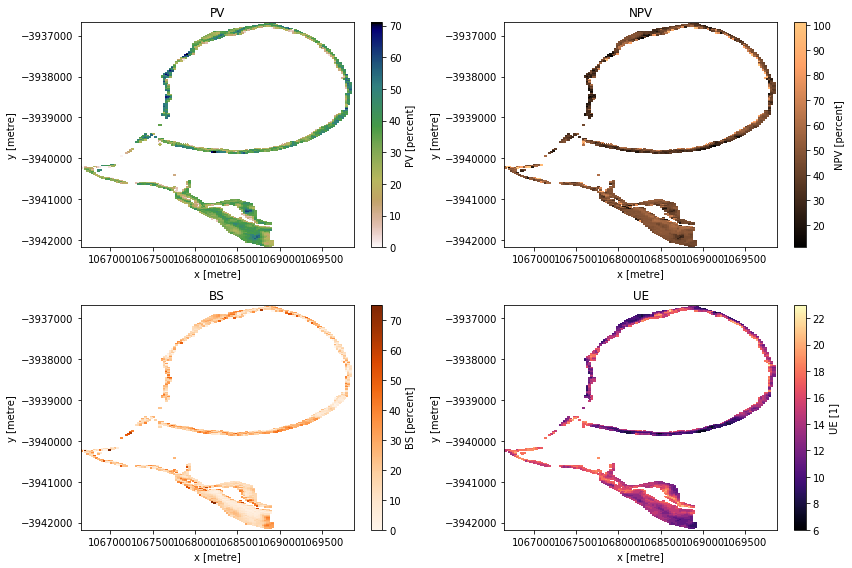

In [240]:
#set up our images on a grid using gridspec
plt.clf()
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
fc_ds_noTCW.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
fc_ds_noTCW.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
fc_ds_noTCW.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
fc_ds_noTCW.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### Calculate number of pixels in area of interest

In [241]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [242]:
mask_xr==0
mask_xr.count(dim=['x','y'])

<xarray.DataArray ()>
array(28380)

In [243]:
#count number of wofs pixels
wofs_pixels = wetwofl.water.sum(dim=['x','y'])

#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100

#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

### Calculate the dominant fraction for each pixel in Fractional Cover

In [244]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

In [246]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [247]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [251]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [255]:
wofs_area_percent=wofs_area_percent.where(wofs_area_percent.time==Bare_soil_percent.time)
wofs_area_percent

<xarray.DataArray (time: 7)>
array([8.408486e+01, 8.379194e+01, 8.876265e-03, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00])
Coordinates:
  * time     (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17

In [253]:
tcw_less_wofs

<xarray.DataArray (time: 7)>
array([-0.301793, -1.109533, 83.117344, 82.016687, 83.570034, 83.951713,
       83.703178])
Coordinates:
  * time     (time) datetime64[ns] 2018-07-02T00:14:28.500000 ... 2018-12-25T00:15:17

In [249]:
query['time'][0]

'2018-07-01'

<Figure size 432x288 with 0 Axes>

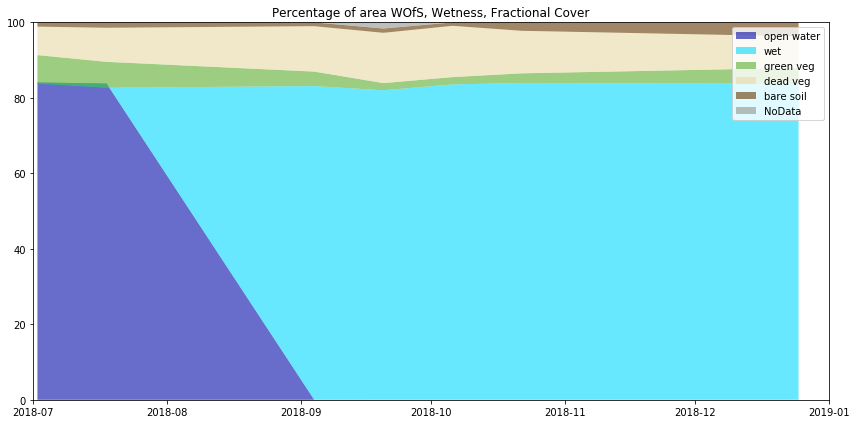

In [257]:
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"],
      sns.xkcd_rgb["grey"]]

#make a stacked area plot
plt.clf()
plt.figure(figsize = (12,6))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent, 
              tcw_less_wofs, 
              Photosynthetic_veg_percent, 
              NonPhotosynthetic_veg_percent,
              Bare_soil_percent,
              NoData,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dead veg',
                      'bare soil',
                      'NoData'
                     ], colors=pal, alpha = 0.6)

plt.title('Percentage of area WOfS, Wetness, Fractional Cover')

#set axis limits to the min and max
plt.axis(xmin = query['time'][0], xmax = query['time'][1], ymin = 0, ymax = 100)

#set date ticks every year
years = mdates.YearLocator(2)
yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(yearsFmt)

#add a legend and a tight plot box
plt.legend(loc='upper right')
plt.tight_layout()

#save the figure
#plt.savefig('/g/data/r78/rjd547/Ramsar_Wetlands/Old_Dromana_Gwydir_2013_2019.png')#, transparent=True)
plt.show()